In [1]:
#!pip install -r requirements.txt

In [2]:
import os
import csv
import numpy as np
from dwave.system import LeapHybridCQMSampler, LeapHybridSampler
from dimod import ConstrainedQuadraticModel, quicksum, Integer, BinaryQuadraticModel, Binary
from dotenv import load_dotenv, find_dotenv
from geopy.distance import geodesic
import matplotlib
try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

from model_builder import build_cqm

In [3]:
# Load Environmental Variables
load_dotenv(find_dotenv())
token = os.environ['DWAVE_API_KEY'] 

In [4]:
def read_data_from_csv(file_path):
    """
    Read data from a CSV file with tab-delimited columns.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        list: A list of tuples containing the data.
            Each tuple has the format (name, latitude, longitude, selected).
    """
    data = []  # Initialize an empty list to store the data

    with open(file_path, 'r') as f:
        reader = csv.DictReader(f, delimiter='\t')  # Specify the delimiter as '\t'
        for row in reader:
            name = row['Location']
            latitude = float(row['Latitude'])
            longitude = float(row['Longitude'])
            selected = int(row['Selected'])
            data.append((name, latitude, longitude, selected))

    return data

In [5]:
def calculate_distance_matrix(data):
    """
    Calculate a distance matrix between locations based on their coordinates.

    Args:
        data (list): A list of tuples containing location data.
            Each tuple should have the format (name, latitude, longitude, selected).

    Returns:
        np.ndarray: A NumPy array representing the distance matrix in kilometers.
    """
    # Extract coordinates and city names
    coordinates = [(lat, lon) for _, lat, lon, _ in data]
    city_names = [city for city, _, _, _ in data]

    # Initialize the distance matrix with zeros
    num_locations = len(data)
    distance_matrix = np.zeros((num_locations, num_locations))

    # Calculate distances using the Haversine formula
    for i in range(num_locations):
        for j in range(num_locations):
            if i != j:
                distance = geodesic(coordinates[i], coordinates[j]).kilometers
                distance_matrix[i][j] = distance

    return distance_matrix

In [6]:
def solve(cqm, time_limit=5):

  """
    Solve the Constrained Quadratic Model (CQM) using the LeapHybridCQMSampler.

    Args:
        cqm (ConstrainedQuadraticModel): The Constrained Quadratic Model to solve.
        time_limit (int): Time limit in seconds for the solver.

    Returns:
        sampleset (SampleSet): The resulting sampleset from the solver.
    """

  sampler = LeapHybridCQMSampler(token=token)
  #print("Submitting CQM to solver {}.".format(sampler.solver.name))
  sampleset = sampler.sample_cqm(cqm, label='TSP', time_limit=time_limit)
  feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)
  if not len(feasible_sampleset):
      raise ValueError("No feasible solution found")
  # Get the lowest feasible energy solution and store the solution variable
  best = feasible_sampleset.first
  return best

In [7]:
def parse_solution(sampleset):

  """
    Parse the solution from the sampleset obtained from the solver.

    Args:
        sampleset (SampleSet): The sampleset obtained from the solver.

    Returns:
        energy (float): The energy of the best solution.
        non_zero_values (dict): Dictionary of non-zero values in the best solution.
    Raises:
        ValueError: If no feasible solution is found in the sampleset.
    """

  
  
  results = [(key, val) for key, val in sampleset.sample.items() if val==1.0]
  energy = sampleset.energy

  city_indices = set()   
  # Extract unique city indices from the decision variable names
  for var_name, _ in results:
      parts = var_name.split('_')
      city_indices.add(int(parts[1]))
      city_indices.add(int(parts[2]))
  
  # Sort the city indices
  sorted_indices = sorted(list(city_indices))
  
  # Initialize a dictionary to map indices to city names
  index_to_city = {i: data[i][0] for i in sorted_indices}
  
  # Initialize a list to represent the tour
  tour = []

  # Sort the results based on the decision variable names
  sorted_results = sorted(results, key=lambda x: int(x[0].split('_')[1]))

  # Create the tour by mapping indices to city names
  for var_name, value in sorted_results:
      parts = var_name.split('_')
      from_city = index_to_city[int(parts[1])]
      to_city = index_to_city[int(parts[2])]
      if value == 1.0:
          tour.append((from_city, to_city))
  
  return energy, tour

In [8]:
def print_solution(solution):

    """
    Print the optimized tour based on the provided solution.

    Args:
        solution (list): The solution luist of tuples containing the the copuple of cities selected
    """

    # Extract city names and coordinates from the data structure
    city_coordinates = {city: (lat, lon) for city, lat, lon, _ in data}

    # Set the figure size 
    plt.figure(figsize=(20, 10));

    # Plot the tour path on the map 
    for from_city, to_city in optimized_tour:
        from_coords = city_coordinates[from_city]
        to_coords = city_coordinates[to_city]

        #  arrows 
        plt.arrow(from_coords[1], from_coords[0],  # Swap lat and long for Matplotlib
                to_coords[1] - from_coords[1], to_coords[0] - from_coords[0],
                head_width=0.5, head_length=0.5, fc='red', ec='blue')

        # Display the city name as text
        plt.text(from_coords[1], from_coords[0], from_city, fontsize=10, ha='right', va='bottom')
        plt.text(to_coords[1], to_coords[0], to_city, fontsize=10, ha='right', va='bottom')

    # Remove x-axis and y-axis labels and ticks
    plt.xticks([])
    plt.yticks([])

    # Print the total cost 
    print(f'Total cost of the tour is: {int(energy)} \n')
    
    print("Optimal Tour:")
    for from_city, to_city in optimized_tour:
        print(f"{from_city} -> {to_city}")

    # Save the plot to a file
    plt.savefig('optimized_tour.png')

    plt.show()
    plt.close()

In [9]:
# Define the path to the CSV file containing location data
file_path = 'locations.csv'

# Read data from the CSV file using a custom function (read_data_from_csv)
data = read_data_from_csv(file_path)

# Select a subset of the first 10 cities from the data
data = data[:10]

# Calculate the distance matrix for the selected subset of cities
distance_matrix = calculate_distance_matrix(data)

Total cost of the tour is: 9951 

Optimal Tour:
Montgomery_AL -> Little-Rock_AR
Phoenix_AZ -> Sacramento_CA
Little-Rock_AR -> Phoenix_AZ
Sacramento_CA -> Boise_ID
Denver_CO -> Hartford_CT
Hartford_CT -> Dover_DE
Dover_DE -> Atlanta_GA
Tallahassee_FL -> Montgomery_AL
Atlanta_GA -> Tallahassee_FL
Boise_ID -> Denver_CO


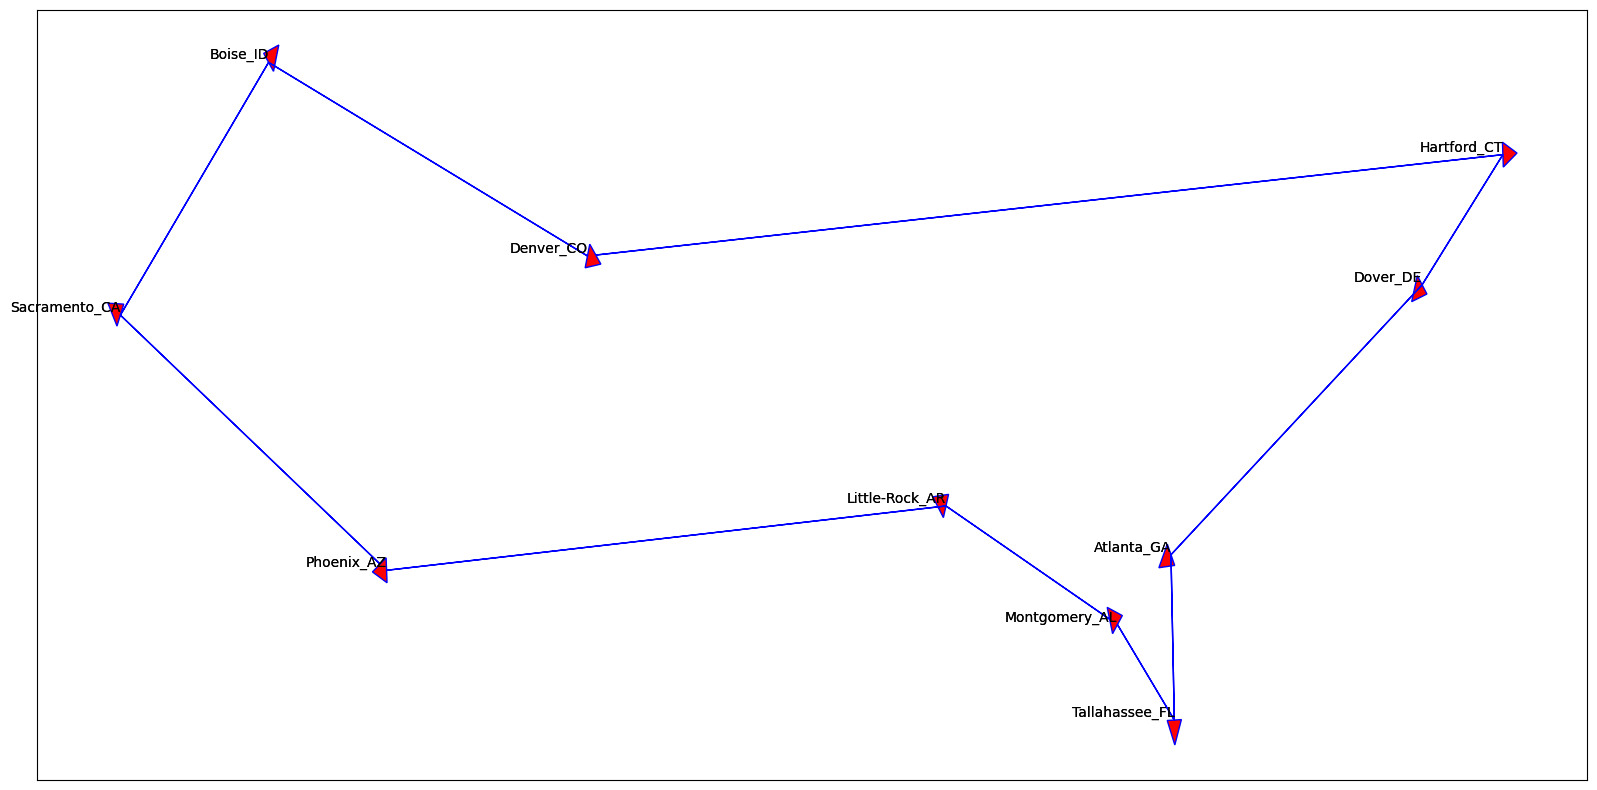

In [10]:
# Initialize CQM
cqm = build_cqm(distance_matrix)

# Instantiate the sampler
sampleset = solve(cqm)

# Parse solution
energy, optimized_tour = parse_solution(sampleset)

# Print solution in a diagram
print_solution(optimized_tour)